# Latent Dirichlet Allocation

In [2]:
import pandas as pd
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from ast import literal_eval

import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from wordcloud import WordCloud

In [3]:
data = pd.read_csv('../out/01-preprocessing.tsv', sep='\t')
data = data[['raw_content', 'username', 'mention', 'cleaned_content']]
data['mention'] = data['mention'].apply(literal_eval)
data_by_mention = data.explode('mention').reset_index(drop=True).copy(deep=True)

In [4]:
grouped_data = {}

In [5]:
data_coldplay = []

In [6]:
for username, df in data.groupby(by='username'):
    df_gd:list = grouped_data.get(username.lower(), [])
    df_gd.append(df)
    grouped_data[username.lower()] = df_gd
    if username != 'coldplay':
        continue
    data_coldplay.append(df)

In [7]:
for username, df in data_by_mention.groupby(by='mention'):
    df_gd:list = grouped_data.get(username.lower(), [])
    df_gd.append(df)
    grouped_data[username.lower()] = df_gd
    if username != 'coldplay':
        continue
    data_coldplay.append(df)

In [8]:
df_coldplay = pd.concat(data_coldplay).reset_index(drop=True)
df_coldplay

,raw_content,username,mention,cleaned_content
0,@rrzzaa__ @IDWantsColdplay I’m so happy to hea...,coldplay,"[rrzzaa__, IDWantsColdplay, thepauldugdale]","['i', 'm', 'so', 'happy', 'hear', 'guys', 'enj..."
1,"Huhu ada lagiii, HALOOO @coldplay https://t.co...",bekstreettt,coldplay,"['huhu', 'lagiii', 'halooo']"
2,Salah satu tanda @coldplay ke Indonesia untuk ...,SeleccionINA,coldplay,"['salah', 'tanda', 'indonesia', 'tur', 'dunia'..."
3,Salah satu tanda @coldplay ke Indonesia untuk ...,SeleccionINA,coldplay,"['salah', 'tanda', 'indonesia', 'tur', 'dunia'..."
4,@IDWantsColdplay @coldplay Bismillah menang wa...,finyjr,coldplay,"['menang', 'war', 'tiket', 'aamiin']"
...,...,...,...,...
1693,@GRhs292374 @IDWantsColdplay @coldplay Hi kaa ...,Silvieoctavian1,coldplay,"['hi', 'kaa', 'buka', 'yah', 'testimony', 'cek..."
1694,@IDWantsColdplay @coldplay Amin 1 tiket😇,everglowstuf,coldplay,"['amin', 'tiket']"
1695,Duetin @coldplay sama @gloriajessicaID di Jaka...,endehendeh,coldplay,"['duetin', 'jakarta', 'coldplayinjakarta']"
1696,@EmirFateh @anwaribrahim @coldplay Zaman Pas P...,mandalorian1605,coldplay,"['zaman', 'pn', 'konsert', 'billie', 'eiliah',..."


In [9]:
content = list(df_coldplay['cleaned_content'].apply(literal_eval))
dictionary = corpora.Dictionary(content)
corpus = [dictionary.doc2bow(doc) for doc in content]

In [65]:
lda_model = models.LdaModel(corpus, num_topics=1, id2word=dictionary, passes=25, random_state=48)

In [72]:
pd.DataFrame(lda_model.show_topics(num_words=15, formatted=False)[0][1], columns=['word', 'prob']).sort_values(by='prob', ascending=False)

,word,prob
0,tiket,0.022680
1,coldplay,0.011564
2,konser,0.010757
3,war,0.010130
4,nonton,0.008606
5,jakarta,0.007978
6,indonesia,0.006544
7,dapet,0.005558
8,moga,0.005468
9,kalo,0.005379


In [66]:
freqs = {}
for word, score in lda_model.show_topics(num_words=15, formatted=False)[0][1]:
  freqs[word] = score

In [67]:
round(lda_model.log_perplexity(corpus), 4)

-7.4875

In [68]:
[round(x, 4) for x in CoherenceModel(model=lda_model, texts=content, dictionary=dictionary, coherence='c_v').get_coherence_per_topic()]

[0.3406]

(-0.5, 399.5, 199.5, -0.5)

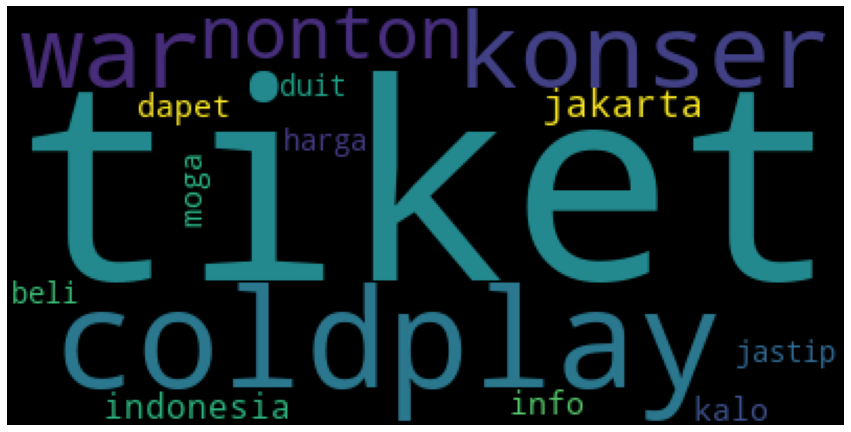

In [69]:
figure(figsize=(15, 15), dpi=72)
plt.imshow(WordCloud().generate_from_frequencies(freqs, max_font_size=400))
plt.axis('off')

In [73]:
lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=25, random_state=48)

In [74]:
freqs = []
for _, topics in lda_model.show_topics(num_words=5, formatted=False):
  freq = {}
  for word, score in topics:
    freq[word] = score
  freqs.append(freq)

In [78]:
pd.DataFrame(freqs[2].items(), columns=['word', 'prob']).sort_values(by='prob', ascending=False)

,word,prob
0,tiket,0.044334
1,war,0.026689
2,coldplay,0.017708
3,nonton,0.014492
4,dapet,0.010696


In [28]:
round(lda_model.log_perplexity(corpus), 4)

-7.7546

In [29]:
[round(x, 4) for x in CoherenceModel(model=lda_model, texts=content, dictionary=dictionary, coherence='c_v').get_coherence_per_topic()]

[0.392, 0.4442, 0.3493]

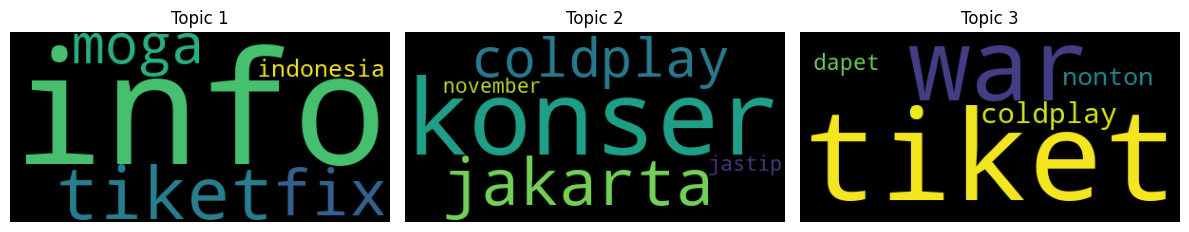

In [64]:
num_freqs = len(freqs)
rows = int(np.ceil(num_freqs / 3))
cols = min(3, num_freqs)
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
for i, freq in enumerate(freqs):
    row, col = divmod(i, cols)
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(WordCloud().generate_from_frequencies(freq, max_font_size=400))
    ax.set_title(f'Topic {i + 1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Export TO JSON

In [18]:
data_output = {}

In [19]:
for username, df in grouped_data.items():
  df = pd.concat(df).reset_index(drop=True)
  content = list(df['cleaned_content'].apply(literal_eval))
  raw_content = list(df['raw_content'])

  try:
    dictionary = corpora.Dictionary(content)
    corpus = [dictionary.doc2bow(doc) for doc in content]
    lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=25, random_state=48)
  except:
    print(username, dictionary, corpus)
    
  topic = []
  for i, x in lda_model.show_topics(num_topics=3, num_words=5, formatted=False):
      topic.append([{'word': word, 'score': str(round(score, 2))} for word, score in x])
      
  data_output[username.lower()] = {
      'topic': topic,
      'source': [{
          'username': u,
          'content': c
      } for u, c in df[['username', 'raw_content']].iloc]
  }

brandze1 Dictionary<0 unique tokens: []> [[]]
sorazkl Dictionary<0 unique tokens: []> [[]]
sampahfajar Dictionary<0 unique tokens: []> [[]]
agungmuhar11194 Dictionary<0 unique tokens: []> [[]]
ambilbulan Dictionary<0 unique tokens: []> [[]]
arthrtitis Dictionary<0 unique tokens: []> [[]]
bedoel28 Dictionary<0 unique tokens: []> [[]]
danilskaka Dictionary<0 unique tokens: []> [[]]
deyybel Dictionary<0 unique tokens: []> [[]]
ebotboti Dictionary<0 unique tokens: []> [[]]
effortlesgenius Dictionary<0 unique tokens: []> [[]]
egustianir Dictionary<0 unique tokens: []> [[]]
faantaesthic Dictionary<0 unique tokens: []> [[]]
farabira Dictionary<0 unique tokens: []> [[]]
freakygurlll_ Dictionary<0 unique tokens: []> [[]]
galih_chie Dictionary<0 unique tokens: []> [[]]
gervasiusbayu Dictionary<0 unique tokens: []> [[]]
gusashdarma Dictionary<0 unique tokens: []> [[]]
harybro Dictionary<0 unique tokens: []> [[]]
himinhere Dictionary<0 unique tokens: []> [[]]
idkhtdrw Dictionary<0 unique tokens: [

In [20]:
output = {
    'data': [{'username': k, 'topic': v['topic'], 'source': v['source']} for k, v in data_output.items()]
}

In [21]:
with open('../out/02-lda-v2.json', 'w') as f:
    json.dump(output, f, indent=4)